In [ ]:
%tensorflow_version 1.x

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import fnmatch

from keras import backend as K

# for the architecture
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D

# optimizer, data generator and learning rate reductor
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.optimizers import SGD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
op_classes = {'Stone':0,'Paper':1,'Scissor':2,'None':3}
len_classes = len(op_classes)

In [ ]:
dataset_path = 'image_dataset'
X_temp = []
Y_temp = []
for dir in os.listdir('/content/drive/My Drive/SPS/'+ str(dataset_path)):
  label_path = os.path.join('/content/drive/My Drive/SPS/'+str(dataset_path),dir)
  if not os.path.isdir(label_path):
    continue
  print('Number of images in {} directory are {}'.format(str(dir),len(fnmatch.filter(os.listdir(label_path), '*.jpg'))))
  for imgs in os.listdir(label_path):
    ximg = cv2.imread(os.path.join(label_path,imgs))
    ximg = cv2.cvtColor(ximg,cv2.COLOR_BGR2RGB)
    ximg = cv2.resize(ximg,(227,227))
    X_temp.append(ximg)
    Y_temp.append(dir)
  print('Completed Data preprocessing for {}'.format(str(dir)))

Y = list(map(lambda x: op_classes[x],Y_temp))

Number of images in Scissor directory are 650
Completed Data preprocessing for Scissor
Number of images in Stone directory are 650
Completed Data preprocessing for Stone
Number of images in Paper directory are 650
Completed Data preprocessing for Paper
Number of images in None directory are 650
Completed Data preprocessing for None


In [ ]:
X_temp = np.array(X_temp)
Y = np.array(Y)
X_temp.shape, Y.shape

((2600, 227, 227, 3), (2600,))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


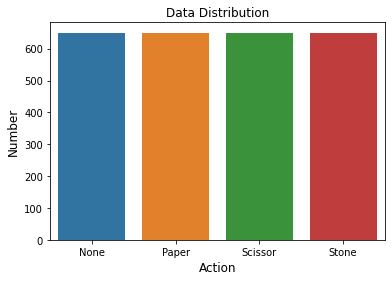

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

value, counts = np.unique(Y_temp, return_counts = True)
plt.figure(figsize = (6,4))
sns.barplot(value,counts)
plt.title('Data Distribution')
plt.ylabel('Number',fontsize = 12)
plt.xlabel('Action',fontsize = 12)
plt.show()

Text(0.5, 1.0, 'Paper')

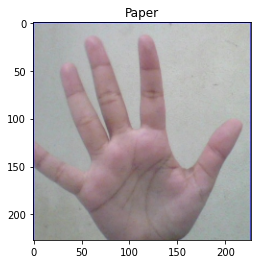

In [ ]:
index = 1520
plt.imshow(X_temp[index])
plt.title(str(Y_temp[index]))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_temp,Y,test_size = 0.25)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1950, 227, 227, 3), (1950,), (650, 227, 227, 3), (650,))

In [ ]:
from keras.utils import np_utils

X_train = X_train.astype('float')
X_test = X_test.astype('float')

# One-Hot encoding 
Y_train = np_utils.to_categorical(Y_train,num_classes = len_classes)
Y_test = np_utils.to_categorical(Y_test,num_classes = len_classes)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1950, 227, 227, 3), (1950, 4), (650, 227, 227, 3), (650, 4))

In [ ]:
from keras import regularizers
model = Sequential()
dim = 227
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(dim,dim,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(AvgPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(AvgPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(AvgPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(len_classes, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 227, 227, 32)      896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 227, 227, 32)      9248      
_________________________________________________________________
average_pooling2d_7 (Average (None, 113, 113, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 113, 113, 64)      18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 113, 113, 64)      36928     
_________________________________________________________________
average_pooling2d_8 (Average (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 128)      

In [ ]:
model.compile(optimizer= Adam(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 8

In [ ]:
history = model.fit(X_train,Y_train,batch_size = batch_size,epochs = epochs,verbose = 1, validation_data = (X_test,Y_test))

Train on 1950 samples, validate on 650 samples
Epoch 1/8
1950/1950 [==============================] - 10s 5ms/step - loss: 18.5677 - accuracy: 0.8492 - val_loss: 11.0723 - val_accuracy: 0.9969
Epoch 2/8
1950/1950 [==============================] - 9s 5ms/step - loss: 9.9087 - accuracy: 0.9995 - val_loss: 9.0835 - val_accuracy: 1.0000
Epoch 3/8
1950/1950 [==============================] - 9s 5ms/step - loss: 8.5357 - accuracy: 1.0000 - val_loss: 8.0229 - val_accuracy: 1.0000
Epoch 4/8
1950/1950 [==============================] - 9s 5ms/step - loss: 7.6344 - accuracy: 0.9944 - val_loss: 7.2591 - val_accuracy: 0.9862
Epoch 5/8
1950/1950 [==============================] - 9s 5ms/step - loss: 6.9184 - accuracy: 0.9949 - val_loss: 6.5757 - val_accuracy: 1.0000
Epoch 6/8
1950/1950 [==============================] - 9s 5ms/step - loss: 6.2874 - accuracy: 1.0000 - val_loss: 6.0089 - val_accuracy: 1.0000
Epoch 7/8
1950/1950 [==============================] - 9s 5ms/step - loss: 5.7688 - accuracy

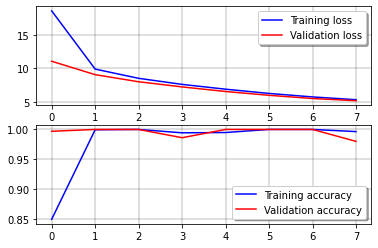

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
model.save('/content/drive/My Drive/SPS/Model_SPS.h5')
print('Saved Model to Disk')

Saved Model to Disk
